In [49]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import pdb

# ODE 

In [50]:
mu=0.05
c=0.01
delta=0.5
K=100
T=5000
sto_realisations=5
rho=0.02 ## wildtypes slowest 
gamma=0.05

In [51]:
def model(y, t, c, K, gamma, delta):
    w1, m1, w2, m2 = y
    dw1_dt = c * w1 * (K - (w1 + delta * m1)) + gamma * (w2 - w1)
    dm1_dt = c * m1 * (K - (w1 + delta * m1)) + gamma * (m2 - m1) 
    dw2_dt = c * w2 * (K - (w2 + delta * m2)) + gamma * (w1 - w2)
    dm2_dt = c * m2 * (K - (w2 + delta * m2)) + gamma * (m1 - m2) 
    return [dw1_dt, dm1_dt, dw2_dt, dm2_dt]

In [52]:

# Conditions initiales
w0 = (1 - 0.5) * K / (1 - 0.5 + rho * 0.5)
m0 = 0.5 * K / (1 - 0.5 + rho * 0.5)
y0 = [w0, m0, w0, m0]

# Temps de simulation
t = np.linspace(0, 5000, 500)

# Résolution du système d'ODE
solution = odeint(model, y0, t, args=(c, K, gamma, delta))


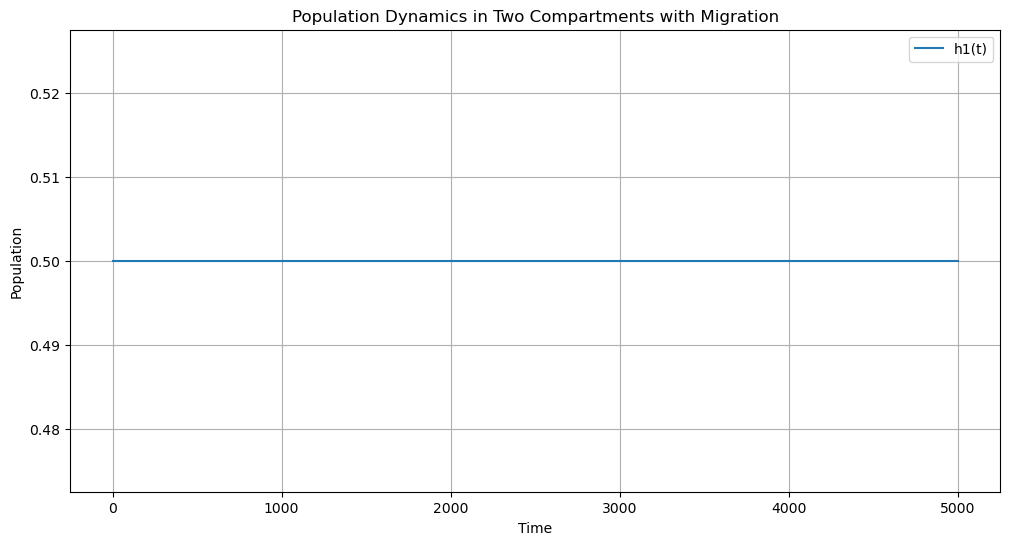

In [53]:

# Extraction des résultats
w1 = solution[:, 0]
m1 = solution[:, 1]
w2 = solution[:, 2]
m2 = solution[:, 3]

h1=m1/(m1+w1)
h2=m2/(m2+w2)

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(t,h1,label="h1(t)")
#plt.plot(t, w1, label='Wildtypes in Compartment 1')
#plt.plot(t, m1, label='Mutants in Compartment 1')
#plt.plot(t, w2, label='Wildtypes in Compartment 2')
#plt.plot(t, m2, label='Mutants in Compartment 2')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Population Dynamics in Two Compartments with Migration')
plt.grid(True)
plt.show()

In [54]:
rho_max= - mu * (delta-1)
print(rho_max)
rho = random.uniform(0, rho_max)
rho_neg= rho_max+2

0.025


In [55]:
h0=0.5
#on essaye d'éviter la division par 0 rho==0 and h0==1
if (delta==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+delta*h0)
    m0 = h0*K/(1-h0+delta*h0)

# Initialisation de l'état initial
X = np.array([w0,m0,w0,m0]) ## on a deux unités 
print(X)

[66.66666667 66.66666667 66.66666667 66.66666667]


In [56]:
def rate_function(rates):
    return max(rates,0)  

In [57]:
V=np.array([[-1, 0, 0, 0, 1,0,0,0, -1,0,1,0], #w1
            [0, -1, 0, 0,0,1,0,0,0,-1,0,1],    #m1
            [0,0,-1,0,0,0,1,0,1,0,-1,0],       #w2
            [0,0,0,-1,0,0,0,1,0,1,0,-1]])     #m2
     

In [73]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0,w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function((mu-rho_max) * X[0]), #death W1
                      rate_function((mu) * X[1]),# death M1
                      rate_function((mu-rho_max) * X[2]), #death W2
                      rate_function((mu)* X[3]), #death M2
                      rate_function((mu - rho_max+ c * (K - X[0] - delta*X[1]))*X[0]), ##birth W1
                      rate_function((mu + c * (K - X[0] - delta*X[1]))*X[1]), ##birth M1
                      rate_function((mu-rho_max+ c * (K - X[2] - delta*X[3]))*X[2]), ##birth W2
                      rate_function((mu + c * (K - X[2] - delta*X[3]))*X[3]), ##birth M2
                      rate_function((gamma-rho_max)*X[0]), #change W1
                      rate_function(gamma*X[1]), #change M1
                      rate_function((gamma-rho_max)*X[2]), #change W2
                      rate_function(gamma*X[3])]) #change M2
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:,j]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)

    

Simulations: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


In [74]:
total_time=5000
time_points = np.linspace(0, total_time, num=20)


# Calculer la fraction de mutants et l'ensemble moyen
h1_ensemble = np.zeros((len(time_points), sto_realisations))
m1_ensemble=np.zeros((len(time_points), sto_realisations))
w1_ensemble=np.zeros((len(time_points), sto_realisations))
h2_ensemble = np.zeros((len(time_points), sto_realisations))
m2_ensemble=np.zeros((len(time_points), sto_realisations))
w2_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W1, M1, W2, M2 = populations[j] if j < len(populations) else populations[-1]
            h1_ensemble[idx, i] = M1 / (W1 + M1)
            m1_ensemble[idx,i]=M1
            w1_ensemble[idx,i]=W1
            
            h2_ensemble[idx, i] = M2 / (W2 + M2)
            m2_ensemble[idx,i]=M2
            w2_ensemble[idx,i]=W2
        else:
            h1_ensemble[idx, i] = h1_ensemble[idx - 1, i]
            m1_ensemble[idx, i] = m1_ensemble[idx - 1, i]
            w1_ensemble[idx, i] = w1_ensemble[idx - 1, i]
            
            
            h2_ensemble[idx, i] = h2_ensemble[idx - 1, i]
            m2_ensemble[idx, i] = m2_ensemble[idx - 1, i]
            w2_ensemble[idx, i] = w2_ensemble[idx - 1, i]

h1_mean = np.mean(h1_ensemble, axis=1)
m1_mean = np.mean(m1_ensemble, axis=1)
w1_mean = np.mean(w1_ensemble, axis=1)

h2_mean = np.mean(h2_ensemble, axis=1)
m2_mean = np.mean(m2_ensemble, axis=1)
w2_mean = np.mean(w2_ensemble, axis=1)

In [75]:
w1_std=np.std(w1_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w1_sem = w1_std/ np.sqrt(sto_realisations)

m1_std=np.std(m1_ensemble,axis=1)
m1_sem = m1_std/ np.sqrt(sto_realisations)
m1_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
w2_std=np.std(w2_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w2_sem = w2_std/ np.sqrt(sto_realisations)


m2_std=np.std(m2_ensemble,axis=1)
m2_sem = m2_std/ np.sqrt(sto_realisations)
m2_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([ 0.        ,  5.30961392, 10.87014259,  9.47164189,  7.55036423,
        6.12796867,  8.72971935,  5.78964593,  9.68710483, 10.38306313,
        1.78885438,  0.71554175,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

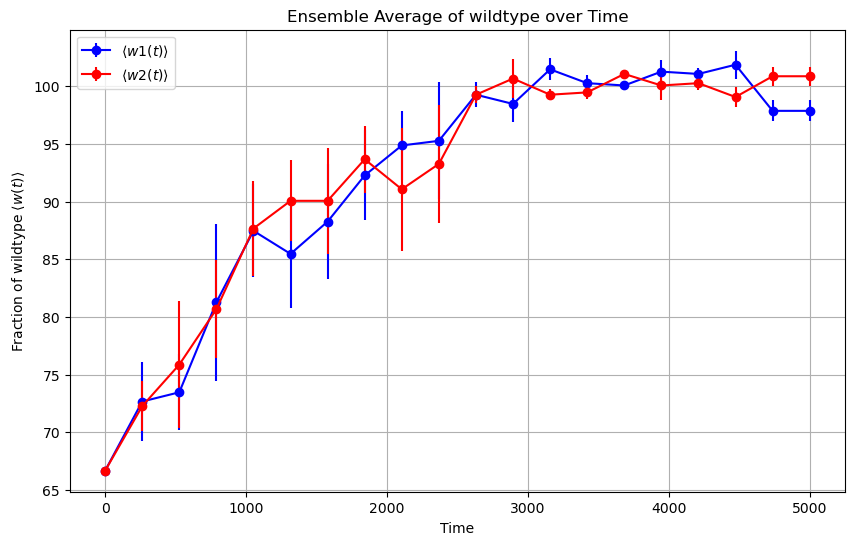

In [76]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, w1_mean, yerr=w1_sem, fmt='b-', marker='o', label=r'$\langle w1(t) \rangle$')
plt.errorbar(time_points, w2_mean, yerr=w2_sem, fmt='r-', marker='o', label=r'$\langle w2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of wildtype $\langle w(t) \rangle$')
plt.title('Ensemble Average of wildtype over Time')
plt.legend()
plt.grid(True)
plt.show()

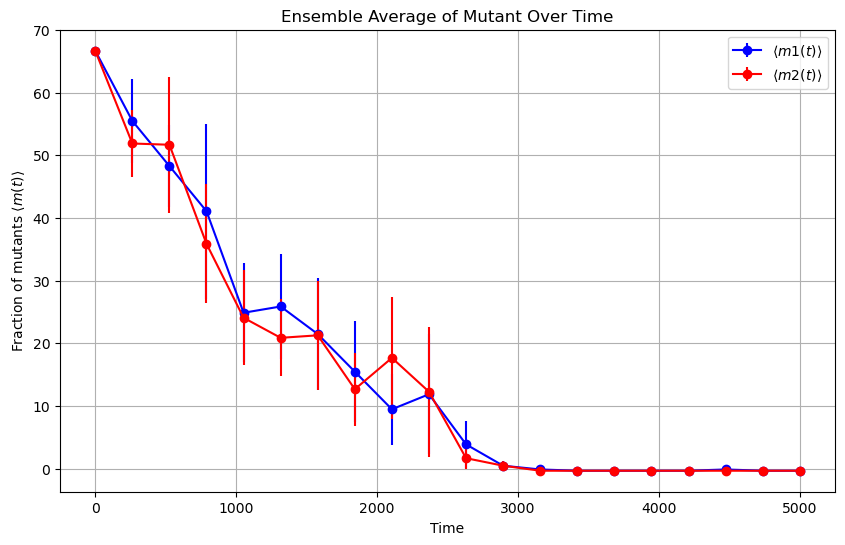

In [77]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m1_mean, yerr=m1_sem, fmt='b-', marker='o', label=r'$\langle m1(t) \rangle$')
plt.errorbar(time_points, m2_mean, yerr=m2_sem, fmt='r-', marker='o', label=r'$\langle m2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle m(t) \rangle$')
plt.title('Ensemble Average of Mutant Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
h1_std=np.std(h1_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h1_sem = h1_std/ np.sqrt(sto_realisations)
h1_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
h2_std=np.std(h2_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h2_sem = h2_std/ np.sqrt(sto_realisations)
h2_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps


array([0.00000000e+00, 3.14618417e-02, 6.67864444e-02, 7.43475467e-02,
       6.19049506e-02, 5.21851736e-02, 6.79686254e-02, 4.98249998e-02,
       7.46982466e-02, 8.00511209e-02, 1.68611698e-02, 7.25636114e-03,
       1.55793670e-05, 2.00340332e-05, 1.18331415e-05, 4.13619393e-05,
       2.03110849e-05, 2.82958508e-05, 2.71935516e-05, 2.71935516e-05])

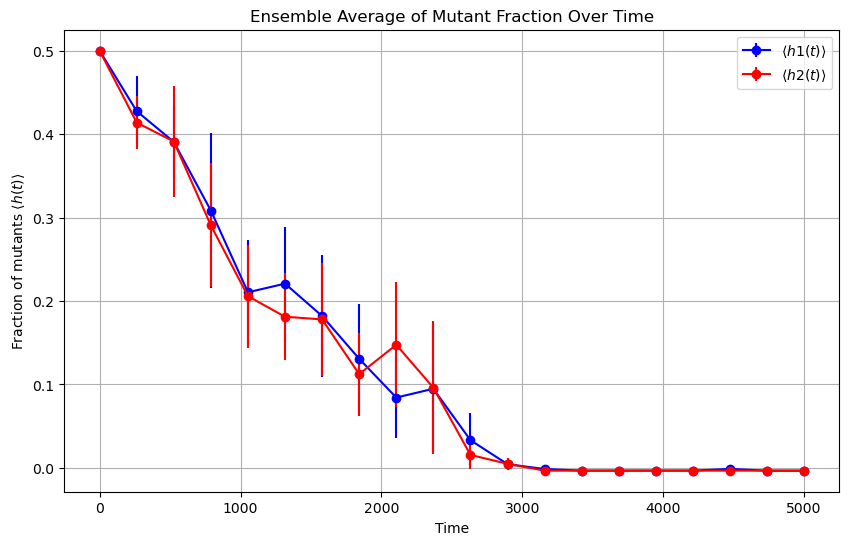

In [79]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h1_mean, yerr=h1_sem, fmt='b-', marker='o', label=r'$\langle h1(t) \rangle$')
plt.errorbar(time_points, h2_mean, yerr=h2_sem, fmt='r-', marker='o', label=r'$\langle h2(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (500,)

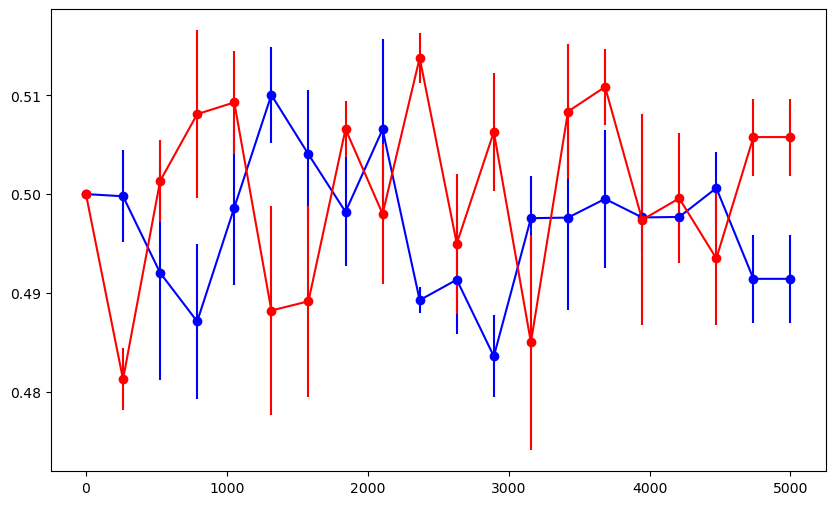

In [72]:

# Tracé des courbes
plt.figure(figsize=(10, 6))

# Tracer la courbe obtenue à partir des simulations
plt.errorbar(time_points, h1_mean, yerr=h1_sem, fmt='b-', marker='o', label=r'$\langle h1(t) \rangle$')
plt.errorbar(time_points, h2_mean, yerr=h2_sem, fmt='r-', marker='o', label=r'$\langle h2(t) \rangle$')
plt.plot(t, h1, 'y', label=r'$h(t)$ from odeint')

# Ajout de légendes
plt.legend()

# Ajout de titres et d'étiquettes d'axes
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Comparison of Mutant Fraction Over Time')
plt.grid(True)

# Affichage du graphe
plt.show()